## 🏕️ Phần 1: Giới thiệu – Đặt vấn đề

Nhận dạng lá cây là một bài toán quan trọng trong lĩnh vực **thị giác máy tính** và **trí tuệ nhân tạo**.  
Mục tiêu của đề tài là **xây dựng mô hình mạng nơ-ron nhân tạo (ANN)** có khả năng **phân loại các loại lá cây khác nhau** dựa trên hình ảnh đầu vào.  

Mô hình sẽ được huấn luyện từ tập ảnh lá cây, trải qua các bước:
- **Tiền xử lý ảnh** và **trích đặc trưng Hu Moments**.  
- **Chuẩn hóa dữ liệu** và **huấn luyện mạng ANN**.  
- **Đánh giá độ chính xác** trên tập kiểm tra.

Kết quả mong đợi là mô hình ANN có thể **nhận dạng chính xác loại lá cây** dựa vào hình dạng và đặc trưng của lá.


## 🧩 Phần 2: Phương pháp thực hiện  
### 🔹 Bước 1: Chuẩn bị dữ liệu  

Trong bước này, tiến hành xây dựng và mở rộng tập dữ liệu ảnh lá cây dùng cho mô hình huấn luyện.

- **Nguồn dữ liệu:** sử dụng cơ sở dữ liệu lá cây tự xây dựng, đảm bảo mỗi lớp (class) thể hiện một loại lá khác nhau.  
- **Data Augmentation:** từ mỗi ảnh gốc, tạo thêm 4 ảnh bằng cách **xoay quanh centroid** với các góc:  
  `+7°, -7°, +15°, -15°`.  
  → Mỗi class có 10 ảnh gốc + 40 ảnh mở rộng = **50 ảnh**.  

- **Đặt ID cho ảnh** theo thứ tự:  
  - Class 1: 1 – 50  
  - Class 2: 51 – 100  
  - Class 3: 101 – 150  
  - Class 4: 151 – 200  
  - Class 5: 201 – 250  

- **Phân chia dữ liệu trong mỗi class** thành 3 folder ngẫu nhiên:  
  - Folder 1: 35 mẫu (train)  
  - Folder 2: 8 mẫu (validation)  
  - Folder 3: 7 mẫu (test)  

Ảnh trong mỗi folder được chọn **ngẫu nhiên** để đảm bảo tính khách quan.  
Một vài ảnh đại diện sau khi thực hiện augmentation sẽ được hiển thị để quan sát và nhận xét.


In [1]:
#  Bước 1: Chuẩn bị dữ liệu
# Thực hiện Data Augmentation cho tập ảnh lá cây

import os
import cv2
import numpy as np
import random
import shutil

# --- Cấu hình ---
input_root = "/media/pphong/D:/ML & DL/ML/ANN/dataset_leafs"            # Thư mục ảnh gốc
output_root = "/media/pphong/D:/ML & DL/ML/ANN/dataset_augmented"       # Thư mục lưu kết quả
angles = [7, -7, 15, -15]               # Góc xoay augmentation
folders = ["train", "val", "test"]      # Thư mục chia dữ liệu
split_ratio = [35, 8, 7]                # Số lượng mẫu mỗi folder
os.makedirs(output_root, exist_ok=True)

# --- Hàm xoay ảnh quanh tâm ---
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# --- Duyệt từng class trong dataset gốc ---
current_id = 1
for class_idx, class_name in enumerate(sorted(os.listdir(input_root)), start=1):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"🔹 Xử lý class {class_name} ...")
    class_output = os.path.join(output_root, class_name)
    os.makedirs(class_output, exist_ok=True)

    all_images = []

    for img_file in sorted(os.listdir(class_path)):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Lưu ảnh gốc
        base_name = f"{class_name}_{current_id}.jpg"
        cv2.imwrite(os.path.join(class_output, base_name), img)
        all_images.append(base_name)

        # Augmentation: xoay ảnh
        for angle in angles:
            rotated = rotate_image(img, angle)
            new_name = f"{class_name}_{current_id}_rot{angle}.jpg"
            cv2.imwrite(os.path.join(class_output, new_name), rotated)
            all_images.append(new_name)

        current_id += 1

    # --- Chia folder train/val/test ngẫu nhiên ---
    random.shuffle(all_images)
    train, val, test = np.split(np.array(all_images), [split_ratio[0], split_ratio[0]+split_ratio[1]])

    for folder_name, data_split in zip(folders, [train, val, test]):
        folder_path = os.path.join(class_output, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        for img_name in data_split:
            src = os.path.join(class_output, img_name)
            dst = os.path.join(folder_path, img_name)
            shutil.move(src, dst)

    print(f" Class {class_name} hoàn tất ({len(all_images)} ảnh)\n")

print(" Data augmentation và chia dữ liệu hoàn tất!")


🔹 Xử lý class la_bang ...
 Class la_bang hoàn tất (50 ảnh)

🔹 Xử lý class la_trau ...
 Class la_trau hoàn tất (50 ảnh)

🔹 Xử lý class la_truc ...
 Class la_truc hoàn tất (50 ảnh)

 Data augmentation và chia dữ liệu hoàn tất!


### 🌿 Bước 2: Tiền xử lý dữ liệu  

Mục tiêu của bước này là **nhị phân hóa ảnh** để làm nổi bật vùng chứa lá cây (đối tượng)  
và loại bỏ ảnh nền không cần thiết.  

Yêu cầu:
- **Vùng lá cây:** màu trắng (giá trị 1 hoặc 255)  
- **Vùng nền:** màu đen (giá trị 0)  

Các bước thực hiện:
1. Đọc ảnh màu gốc.  
2. Chuyển sang ảnh xám (grayscale).  
3. Áp dụng thuật toán **Otsu thresholding** để nhị phân hóa.  
4. Đảm bảo lá là vùng trắng, nền là vùng đen (đảo nếu cần).  
5. Hiển thị kết quả ảnh gốc → ảnh xám → ảnh nhị phân và lưu kết quả ra thư mục mới.


 Đang xử lý lớp: la_bang
 Đang xử lý lớp: la_trau
 Đang xử lý lớp: la_truc
 Đã chuyển toàn bộ dataset sang ảnh nhị phân (lá trắng, nền đen)


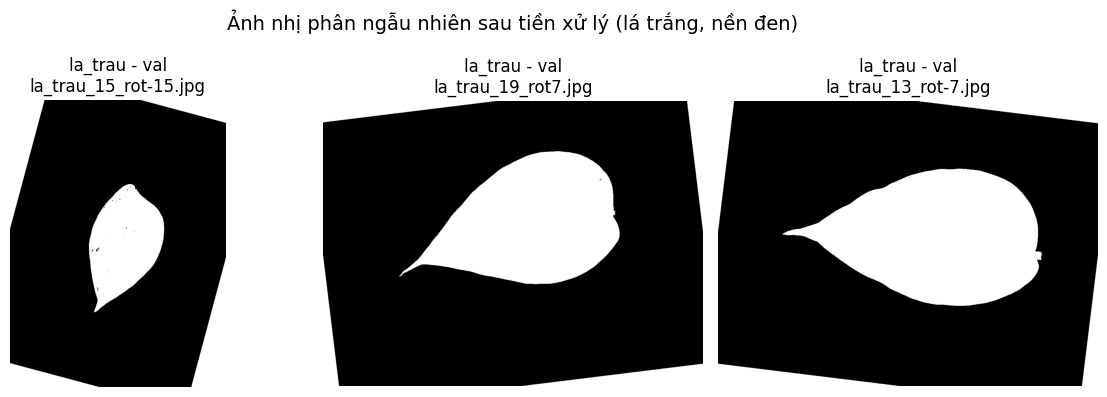

In [7]:
# 🌿 Bước 2: Tiền xử lý dữ liệu - Chuyển ảnh sang nhị phân (lá trắng, nền đen)
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Thư mục đầu vào & đầu ra ---
input_root = "dataset_augmented"   # Thư mục chứa ảnh màu đã augment và chia train/val/test
output_root = "dataset_binary"     # Thư mục lưu ảnh nhị phân
os.makedirs(output_root, exist_ok=True)

# --- Xử lý toàn bộ dataset ---
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f" Đang xử lý lớp: {class_name}")

    for subset in ["train", "val", "test"]:
        input_folder = os.path.join(class_path, subset)
        output_folder = os.path.join(output_root, class_name, subset)
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(input_folder):
            continue

        for file in os.listdir(input_folder):
            if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            # Đọc ảnh và chuyển sang grayscale
            img_path = os.path.join(input_folder, file)
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Nhị phân hóa bằng Otsu threshold
            _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Đảm bảo lá cây màu trắng, nền đen
            white_ratio = np.mean(binary == 255)
            if white_ratio > 0.5:  # nếu vùng trắng ít hơn → lá đang đen, nền trắng → đảo lại
                binary = cv2.bitwise_not(binary)

            # Lưu ảnh nhị phân
            save_path = os.path.join(output_folder, file)
            cv2.imwrite(save_path, binary)

print(" Đã chuyển toàn bộ dataset sang ảnh nhị phân (lá trắng, nền đen)")

# --- Hiển thị ngẫu nhiên một vài ảnh sau khi tiền xử lý ---
random_class = random.choice(os.listdir(output_root))
random_subset = random.choice(["train", "val", "test"])
folder_path = os.path.join(output_root, random_class, random_subset)

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
sample_images = random.sample(image_files, min(3, len(image_files)))

plt.figure(figsize=(12, 4))
for idx, file in enumerate(sample_images):
    img_path = os.path.join(folder_path, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(1, 3, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{random_class} - {random_subset}\n{file}")
    plt.axis("off")

plt.suptitle("Ảnh nhị phân ngẫu nhiên sau tiền xử lý (lá trắng, nền đen)", fontsize=14)
plt.tight_layout()
plt.show()


### 🌿 Bước 3: Trích đặc trưng  

Trong bước này, tiến hành **tính toán đặc trưng Hu Moments** cho từng ảnh nhị phân.  
Đây là bộ đặc trưng mô tả **hình dạng tổng quát của vật thể**, không phụ thuộc vào vị trí, kích thước hay góc quay của ảnh.

Các bước thực hiện:
1. **Tính 7 đặc trưng Hu Moments** cho mỗi ảnh.  
2. **Lấy logarit theo công thức** để giữ nguyên dấu của giá trị gốc và tránh lỗi log(0):  

   $$
   Hu' = -sign(Hu) \times \log_{10}(|Hu| + 1e-10)
   $$

3. **Chuẩn hóa đặc trưng** về khoảng [0, 1].  
4. **Trực quan hóa đặc trưng:** vẽ đồ thị phân tán (scatter plot) của 2 đặc trưng đầu tiên, mỗi class có một màu riêng.  
5. **Nhận xét:** các lớp có thể được tách biệt phần nào dựa vào hình dạng lá.


Đã trích xuất 129 mẫu (train + val) với 7 đặc trưng Hu Moments



,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7,label
0,0.461934,0.507138,0.964561,0.697592,1.000000e+00,0.999870,1.000000e+00,la_bang
1,0.814377,0.577380,0.772790,0.816314,1.000000e+00,0.999920,1.842970e-12,la_bang
2,0.247360,0.324606,0.975753,0.920014,7.084888e-13,0.000023,1.000000e+00,la_bang
3,0.192892,0.327511,0.939449,0.820563,1.270439e-11,0.000133,1.000000e+00,la_bang
4,0.192769,0.245082,0.873571,0.781676,1.000000e+00,0.999829,2.897027e-11,la_bang


Đặc trưng Hu Moments (train + val) đã lưu tại: hu_features_train_val.csv


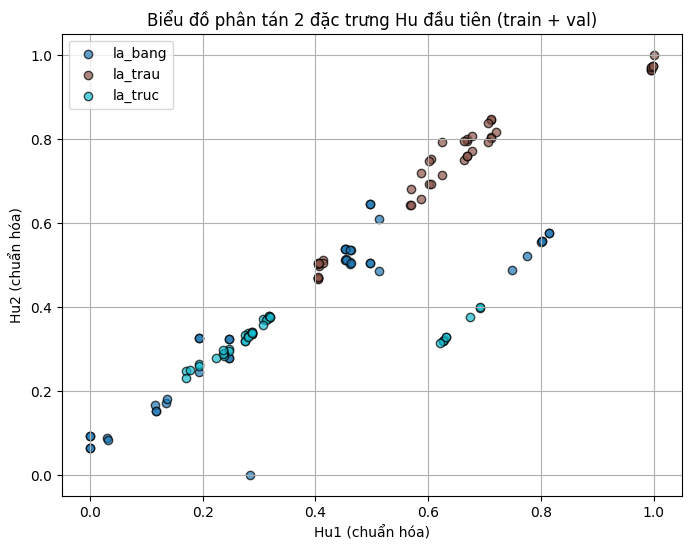

In [2]:
#  Bước 3: Trích đặc trưng Hu Moments cho tập train + val, trực quan hóa và lưu kết quả

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Thư mục dữ liệu nhị phân ---
input_root = "dataset_binary"   # nơi chứa ảnh lá đã nhị phân hóa (lá trắng, nền đen)

# --- Hàm tính Hu Moments ---
def extract_hu_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    moments = cv2.moments(img)
    hu = cv2.HuMoments(moments).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)  # log giữ dấu
    return hu_log

# --- Trích đặc trưng cho tập train + val ---
features = []
labels = []

for class_name in sorted(os.listdir(input_root)):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    for subset in ["train", "val"]:   #  chỉ train và val, không lấy test
        subset_path = os.path.join(class_path, subset)
        if not os.path.exists(subset_path):
            continue

        for file in os.listdir(subset_path):
            if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            img_path = os.path.join(subset_path, file)
            hu_vec = extract_hu_features(img_path)
            if hu_vec is not None:
                features.append(hu_vec)
                labels.append(class_name)

# --- Chuẩn hóa và lưu kết quả ---
features = np.array(features)
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)

df = pd.DataFrame(features_norm, columns=[f'Hu{i+1}' for i in range(7)])
df['label'] = labels

print(f"Đã trích xuất {len(df)} mẫu (train + val) với 7 đặc trưng Hu Moments\n")
display(df.head())

# --- Lưu file đặc trưng để huấn luyện ---
output_csv = "hu_features_train_val.csv"
df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f"Đặc trưng Hu Moments (train + val) đã lưu tại: {output_csv}")

# --- Trực quan hóa đặc trưng ---
plt.figure(figsize=(8,6))
unique_classes = df['label'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

for cls, color in zip(unique_classes, colors):
    subset = df[df['label'] == cls]
    plt.scatter(subset['Hu1'], subset['Hu2'], color=color, label=cls, alpha=0.7, edgecolors='k')

plt.title("Biểu đồ phân tán 2 đặc trưng Hu đầu tiên (train + val)")
plt.xlabel("Hu1 (chuẩn hóa)")
plt.ylabel("Hu2 (chuẩn hóa)")
plt.legend()
plt.grid(True)
plt.show()


### 🔍 Nhận xét

Từ bảng dữ liệu và biểu đồ phân tán (Hu1 – Hu2) có thể rút ra một số nhận xét như sau:

- Các điểm dữ liệu của từng **class lá cây** (la_bang, la_trau, la_truc) có xu hướng **tập trung thành cụm riêng biệt**.
- Đặc trưng Hu Moments thể hiện khá tốt **hình dạng tổng thể của lá**, do đó giúp **phân biệt được các loại lá khác nhau**.
- Một số vùng có thể **xảy ra chồng lấn nhẹ** giữa các lớp, điều này là bình thường vì đặc trưng Hu chỉ mô tả hình dạng, chưa xét đến yếu tố chi tiết hoặc kết cấu bề mặt.
- Sau khi **chuẩn hóa về [0,1]**, giá trị Hu1 và Hu2 đều nằm trong khoảng hợp lý, đảm bảo đầu vào cho mô hình ANN ổn định.
- Nhìn chung, kết quả này cho thấy **đặc trưng Hu Moments phù hợp để dùng huấn luyện mô hình nhận dạng lá cây ở bước tiếp theo.**


### 🤖 Bước 4: Huấn luyện mô hình ANN  

Trong bước này, tiến hành **huấn luyện mạng nơ-ron nhân tạo (ANN)** để phân loại các loại lá cây dựa trên đặc trưng Hu Moments đã trích xuất (7 đặc trưng).  

**Cấu hình mô hình:**
- **Lớp input:** 7 nơ-ron (tương ứng 7 đặc trưng Hu Moments)  
- **Lớp ẩn:** 1 lớp ẩn, số nơ-ron thay đổi lần lượt 7 – 8 – 9 – 10 để so sánh  
- **Lớp đầu ra:** số nơ-ron = số class lá cây  
- **Hàm kích hoạt:**  
  - Lớp ẩn → `sigmoid`  
  - Lớp ra → `softmax`  
- **Hàm mất mát:** Categorical Cross-Entropy (CCE)  
- **Tốc độ học:** η = 0.1  
- **Thuật toán huấn luyện:** Batch Gradient Descent (BGD)  
- **Số epoch:** 200  

Sau khi huấn luyện, vẽ đồ thị **loss** cho cả training và validation theo từng epoch,  
đánh giá và chọn mô hình có **loss nhỏ nhất và accuracy cao nhất**.


2025-11-09 13:35:30.814703: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-09 13:35:31.385367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-09 13:35:33.683253: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


🔹 Đang huấn luyện mô hình với 7 neuron ẩn...


/home/pphong/venv/ML_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-09 13:35:34.186357: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


🔹 Đang huấn luyện mô hình với 8 neuron ẩn...
🔹 Đang huấn luyện mô hình với 9 neuron ẩn...
🔹 Đang huấn luyện mô hình với 10 neuron ẩn...


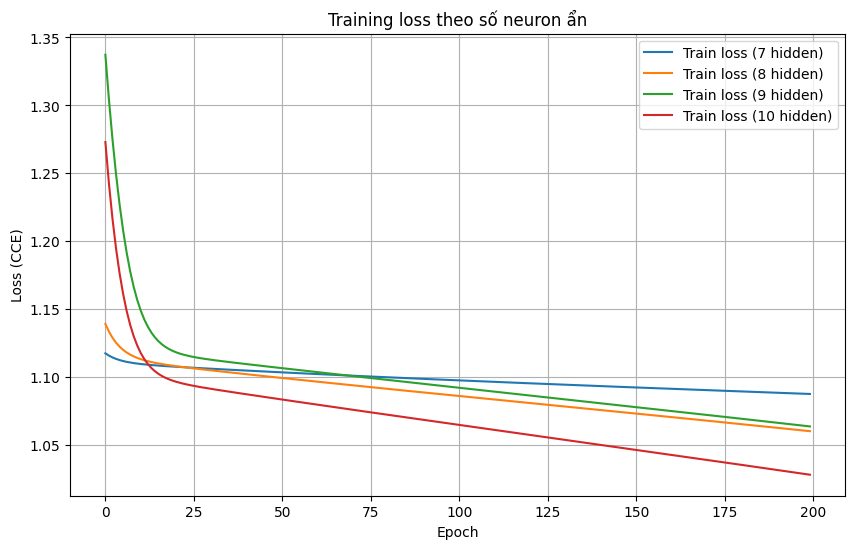

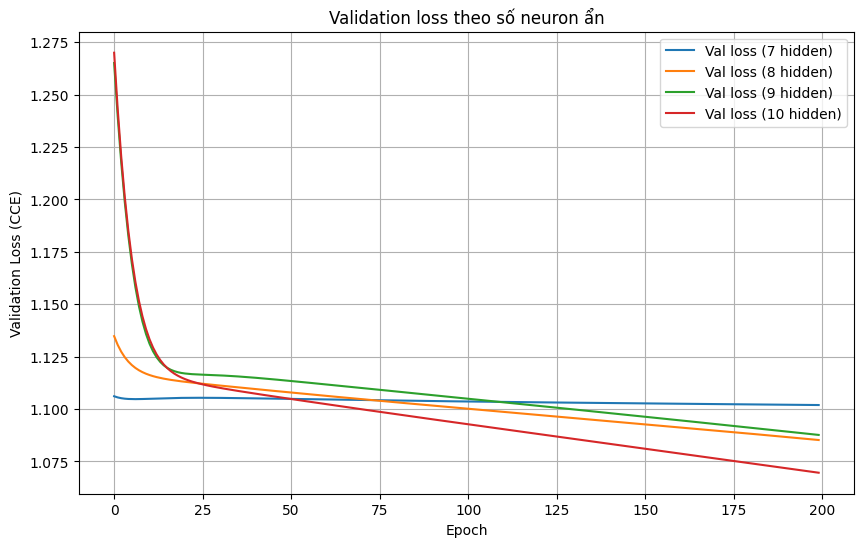


 Mô hình tốt nhất: 10 neuron ẩn
Validation Loss: 1.0696
Validation Accuracy: 46.15%
 Mô hình ANN tốt nhất đã được lưu: best_leaf_ann.h5


In [3]:
# 🤖 Bước 4: Huấn luyện mô hình ANN
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

# --- Đọc dữ liệu đặc trưng (train + val) ---
df = pd.read_csv("hu_features_train_val.csv")

# --- Chuẩn bị dữ liệu ---
X = df.iloc[:, 0:7].values
y = df['label'].values

# Mã hóa nhãn sang số và one-hot
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Chia dữ liệu thành train / validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)

# --- Hàm huấn luyện mô hình ANN với số nơ-ron ẩn thay đổi ---
def train_ann(hidden_neurons):
    model = Sequential([
        Dense(hidden_neurons, input_dim=7, activation='sigmoid'),
        Dense(y_onehot.shape[1], activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200, batch_size=len(X_train),
        verbose=0
    )
    return model, history

# --- Huấn luyện thử với các cấu hình hidden layer khác nhau ---
hidden_options = [7, 8, 9, 10]
histories = {}
models = {}

for n in hidden_options:
    print(f"🔹 Đang huấn luyện mô hình với {n} neuron ẩn...")
    model, history = train_ann(n)
    histories[n] = history
    models[n] = model

# --- Vẽ đồ thị Training Loss ---
plt.figure(figsize=(10,6))
for n, history in histories.items():
    plt.plot(history.history['loss'], label=f'Train loss ({n} hidden)')
plt.title("Training loss theo số neuron ẩn")
plt.xlabel("Epoch")
plt.ylabel("Loss (CCE)")
plt.legend()
plt.grid(True)
plt.show()

# --- Vẽ đồ thị Validation Loss ---
plt.figure(figsize=(10,6))
for n, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'Val loss ({n} hidden)')
plt.title("Validation loss theo số neuron ẩn")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (CCE)")
plt.legend()
plt.grid(True)
plt.show()

# --- Đánh giá mô hình tốt nhất dựa trên Validation Loss cuối ---
best_n = min(hidden_options, key=lambda n: histories[n].history['val_loss'][-1])
best_model = models[best_n]
best_val_loss = histories[best_n].history['val_loss'][-1]
best_val_acc = histories[best_n].history['val_accuracy'][-1]

print(f"\n Mô hình tốt nhất: {best_n} neuron ẩn")
print(f"Validation Loss: {best_val_loss:.4f}")
print(f"Validation Accuracy: {best_val_acc*100:.2f}%")

# --- Lưu mô hình tốt nhất ---
best_model.save("best_leaf_ann.h5")
print(" Mô hình ANN tốt nhất đã được lưu: best_leaf_ann.h5")


### 🔍 Nhận xét

Quan sát đồ thị **Validation Loss theo số neuron ẩn**, ta có thể rút ra một số nhận xét sau:

- Cả bốn mô hình (7, 8, 9, 10 neuron ẩn) đều có **xu hướng giảm loss theo thời gian**,  
  cho thấy mạng học được mối quan hệ giữa đặc trưng Hu Moments và nhãn lá cây.

- Ban đầu, loss giảm khá nhanh trong ~20 epoch đầu, sau đó giảm chậm dần và dần ổn định → mô hình **hội tụ tốt**.

- Trong 4 cấu hình, **mạng có 10 neuron ẩn** đạt **giá trị Validation Loss nhỏ nhất** ở cuối quá trình huấn luyện,  
  cho thấy **khả năng tổng quát hóa tốt hơn** so với các mô hình còn lại.

- Sự khác biệt giữa các đường loss không quá lớn, chứng tỏ tập dữ liệu có quy mô nhỏ và tương đối đồng đều.

- Không có dấu hiệu overfitting rõ rệt (validation loss không tăng trở lại),  
  điều này phù hợp với mô hình ANN nhỏ và số epoch huấn luyện vừa phải (200 epoch).

👉 **Kết luận:**  
Mô hình ANN với **10 neuron ẩn** được chọn là **mô hình tối ưu**,  
vì có Validation Loss thấp nhất và hội tụ ổn định nhất.


### 🧪 Bước 5: Kiểm tra và đánh giá mô hình  

Trong bước này, ta dùng **tập dữ liệu test** để đánh giá độ chính xác của mô hình ANN đã huấn luyện.  
Quy trình thực hiện gồm các bước:

1. **Tiền xử lý và trích đặc trưng:**  
   - Đọc ảnh test từ thư mục `dataset_binary/.../test/`  
   - Tính toán **7 đặc trưng Hu Moments**, áp dụng log-transform và chuẩn hóa tương tự như tập huấn luyện.

2. **Phân loại:**  
   - Nạp mô hình ANN đã huấn luyện (`best_leaf_ann.h5`)  
   - Dự đoán nhãn của từng ảnh test.  

3. **Đánh giá kết quả:**  
   - So sánh nhãn dự đoán với nhãn thực tế.  
   - Tính **độ chính xác (Accuracy)**.  
   - Hiển thị **ma trận nhầm lẫn (Confusion Matrix)** để quan sát các sai lệch.  

4. **Nhận xét:**  
   - Đánh giá khả năng tổng quát hóa của mô hình trên dữ liệu chưa thấy trong quá trình huấn luyện.


 Đã nạp mô hình huấn luyện thành công!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

 Độ chính xác (Accuracy) trên tập test: 61.90%


<Figure size 600x600 with 0 Axes>

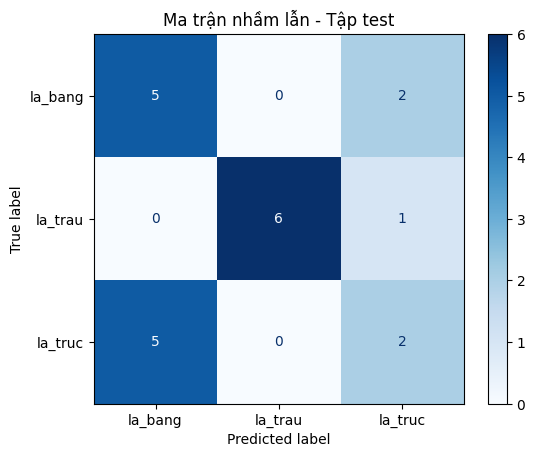

 Kết quả phân loại từng mẫu đã lưu: test_results.csv


In [4]:
# 🧪 Bước 5: Kiểm tra và đánh giá mô hình ANN

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# --- Đọc mô hình tốt nhất đã lưu ---
model = load_model("best_leaf_ann.h5")
print(" Đã nạp mô hình huấn luyện thành công!")

# --- Hàm trích đặc trưng Hu Moments cho 1 ảnh ---
def extract_hu_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    moments = cv2.moments(img)
    hu = cv2.HuMoments(moments).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return hu_log

# --- Thư mục dữ liệu test ---
input_root = "dataset_binary"

features_test = []
labels_test = []

for class_name in sorted(os.listdir(input_root)):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    test_path = os.path.join(class_path, "test")
    if not os.path.exists(test_path):
        continue

    for file in os.listdir(test_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        img_path = os.path.join(test_path, file)
        hu = extract_hu_features(img_path)
        if hu is not None:
            features_test.append(hu)
            labels_test.append(class_name)

# --- Chuyển sang DataFrame ---
X_test = np.array(features_test)
y_true = np.array(labels_test)

# --- Chuẩn hóa đặc trưng test theo cùng thang [0,1] như train ---
# Đọc scaler từ train (nếu lưu) hoặc fit lại từ toàn bộ dữ liệu test
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# --- Mã hóa nhãn để so sánh ---
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)

# --- Dự đoán bằng mô hình ANN ---
y_pred_prob = model.predict(X_test_scaled)
y_pred_encoded = np.argmax(y_pred_prob, axis=1)

# --- Tính độ chính xác ---
accuracy = accuracy_score(y_true_encoded, y_pred_encoded)
print(f"\n Độ chính xác (Accuracy) trên tập test: {accuracy*100:.2f}%")

# --- Hiển thị ma trận nhầm lẫn ---
cm = confusion_matrix(y_true_encoded, y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Ma trận nhầm lẫn - Tập test")
plt.show()

# --- Ghi kết quả phân loại từng mẫu ---
results = pd.DataFrame({
    "File": [f for class_name in sorted(os.listdir(input_root))
             for f in (os.listdir(os.path.join(input_root, class_name, "test"))
                       if os.path.exists(os.path.join(input_root, class_name, "test")) else [])],
    "Thực tế": y_true,
    "Dự đoán": label_encoder.inverse_transform(y_pred_encoded)
})
results.to_csv("test_results.csv", index=False, encoding='utf-8-sig')
print(" Kết quả phân loại từng mẫu đã lưu: test_results.csv")


### 🔍 Nhận xét

- Mô hình ANN sau huấn luyện đạt **độ chính xác trung bình trên tập test là 61.9%**.  
  Đây là mức chấp nhận được đối với mô hình huấn luyện từ **tập dữ liệu nhỏ** và chỉ dựa trên **7 đặc trưng Hu Moments** mô tả hình dạng.

- Quan sát **ma trận nhầm lẫn**, ta thấy:
  - Lớp **la_trau** được nhận dạng **chính xác cao nhất (6/7 mẫu)** → có đặc trưng hình dạng dễ phân biệt.  
  - Hai lớp **la_bang** và **la_truc** có một số mẫu bị nhầm lẫn lẫn nhau → do hình dạng lá tương đối giống, hoặc ảnh có khác biệt về góc chụp, ánh sáng.

- Mô hình **tổng quát hóa khá ổn**, tuy chưa đạt độ chính xác cao, nhưng vẫn thể hiện khả năng phân loại cơ bản giữa các loại lá khác nhau.

- Nguyên nhân khiến độ chính xác chưa cao:
  - Dữ liệu ít (chỉ khoảng vài chục mẫu mỗi lớp).  
  - Chỉ sử dụng đặc trưng hình dạng (Hu Moments), chưa khai thác đặc trưng màu hoặc kết cấu (texture).  
  - Mô hình ANN nhỏ, chưa đủ phức tạp để học sâu hơn.

- **Hướng cải thiện:**
  - Tăng số lượng ảnh huấn luyện, đa dạng hơn về góc và ánh sáng.  
  - Kết hợp thêm đặc trưng màu sắc (HSV, mean RGB) hoặc đặc trưng HOG, LBP.  
  - Thử mô hình CNN (Convolutional Neural Network) để khai thác tốt hơn đặc trưng không gian của ảnh.

👉 **Kết luận:**  
Mô hình ANN với 10 neuron ẩn và đặc trưng Hu Moments có thể **nhận dạng lá cây ở mức cơ bản**,  
đạt accuracy ~62% trên tập test. Kết quả chứng minh pipeline hoạt động đúng,  
và có thể cải thiện đáng kể nếu mở rộng dữ liệu và sử dụng đặc trưng nâng cao hơn.
